# Sentiment Analysis
Sentiment Analysis model to classify Yelp reviews as positive or negative, based on the text of the review.

**Dataset:** [Yelp Review Sentiment Dataset](https://www.kaggle.com/datasets/ilhamfp31/yelp-review-dataset/data)



# SetUp

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, GRU, LSTM, Dropout
from tensorflow.keras import utils
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import re
import shutil
import string

from tensorflow.keras import layers
from tensorflow.keras import losses


In [37]:
print(tf.__version__)

2.18.0


In [38]:
num_words = 10000
max_review_len = 200
batch_size = 32
seed = 42

# Load Data

- The number of label should be interpretated as:
    - '2' - a good review
    - '1' - a bad one.
    
- Let's change the encoding to the
    - '1' - a good review
    - '0' - a bad one

In [39]:
train = pd.read_csv('train.csv',
                   header=None,
                   names=['Label', 'Review'])
test = pd.read_csv('test.csv',
                   header=None,
                   names=['Label', 'Review'])

In [40]:
y_train, y_test = train['Label'] - 1, test['Label'] - 1
x_train = train['Review']
x_test = test['Review']

Let's take a look at a few reviews.

In [41]:
reviews = train['Review']
reviews[:5]

,Review
0,"Unfortunately, the frustration of being Dr. Go..."
1,Been going to Dr. Goldberg for over 10 years. ...
2,I don't know what Dr. Goldberg was like before...
3,I'm writing this review to give you a heads up...
4,All the food is great here. But the best thing...


# Preprocessing

using tf.keras.layers.TextVectorization layer and custom functions:


## Tokenization
to splitting strings into tokens.

In [42]:
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(reviews)
# tokenizer.word_index

## Vectorization
to converting tokens into numbers.

In [43]:
# Now we can transform the reviews to it's numerical value
sequences = tokenizer.texts_to_sequences(reviews)

In [44]:
# Let's try to match the dictionary values and the reviews
index = 42
print(reviews[index])
print(sequences[index])

Some of the worst pizza I've ever had.  We used a coupon from the paper for a 2 topping 8 cut Sicilian. First of all the pizza wasn't even cut through, and the sad attempt at cutting was so uneven that 4 of the slices were about an inch wide, while the others were about 4\" each. The toppings were scarce, they used mini pepperoni and put maybe 8 on the whole pizza. The onions were huge chunks and the mushrooms were straight from a can. The worst part though was the thick doughy crust that tasted more like a fishy sourdough roll. I'm serious... It was so noticeable that it made me wonder if the dough was bad or if they for some weird reason put fish sauce in it. It was gross. \n\nWe also ordered steak and Italian hoagies. The veggies were old and wilted, and there was no dressing on either. The Italian had deli meat that was clearly bottom of the line and not very generous. The \"steak\" (if you an call it that) was greyish instead of brown and looked like it was a processed meat choppe

In [45]:
print(tokenizer.word_index['some'])
print(tokenizer.word_index['of'])
print(tokenizer.word_index['the'])
print(tokenizer.word_index['worst'])

67
7
1
384


In [46]:
# we should limit the sequnces length, the shorter reviews will be added by zeroes, the longer will be cut
x_train = pad_sequences(sequences, maxlen=max_review_len)
x_train[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,  707,    1, 4339,    7,  173,  939, 1665,   11,    5,
       2161,    7,    1,  137,  112,   24,   18,   27,  189,   80, 3128,
         10, 2636,   34, 1416,  462,  129,    8,  519,   13,  177,  129,
        803,   88, 3812,    1,  446,    8,  392,  841,  115,  360,    7,
       4136, 1438,    4,   43,   59, 1266,  118,   95,   46,    9,   13,
         49, 1687,    4,  418,   18,    8,    3,   

# Create the Model

In [47]:
model = tf.keras.Sequential([
  Embedding(num_words, 64, input_length=max_review_len),
  GRU(128),
  layers.Dense(1, activation='sigmoid')])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

# Model Compile

In [48]:
model.compile(loss=losses.BinaryCrossentropy(),
              optimizer='adam',
              metrics=[tf.metrics.BinaryAccuracy(threshold=0.5)])

In [49]:
model_save_path = './best_model.h5'
checkpoint_callback = ModelCheckpoint(model_save_path,
                                      monitor='val_binary_accuracy',
                                      save_best_only=True,
                                      verbose=1)

# Model Training

In [50]:
history = model.fit(x_train,
                    y_train,
                    epochs=5,
                    batch_size=128,
                    validation_split=0.1,
                    callbacks=[checkpoint_callback])

Epoch 1/5
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.8970 - loss: 0.2373
Epoch 1: val_binary_accuracy improved from -inf to 0.95812, saving model to ./best_model.h5


3938/3938 ━━━━━━━━━━━━━━━━━━━━ 61s 15ms/step - binary_accuracy: 0.8970 - loss: 0.2373 - val_binary_accuracy: 0.9581 - val_loss: 0.1086
Epoch 2/5
3936/3938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.9545 - loss: 0.1192
Epoch 2: val_binary_accuracy improved from 0.95812 to 0.96482, saving model to ./best_model.h5


3938/3938 ━━━━━━━━━━━━━━━━━━━━ 59s 15ms/step - binary_accuracy: 0.9545 - loss: 0.1192 - val_binary_accuracy: 0.9648 - val_loss: 0.0928
Epoch 3/5
3936/3938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.9660 - loss: 0.0909
Epoch 3: val_binary_accuracy improved from 0.96482 to 0.96600, saving model to ./best_model.h5


3938/3938 ━━━━━━━━━━━━━━━━━━━━ 84s 16ms/step - binary_accuracy: 0.9660 - loss: 0.0909 - val_binary_accuracy: 0.9660 - val_loss: 0.0936
Epoch 4/5
3936/3938 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - binary_accuracy: 0.9732 - loss: 0.0741
Epoch 4: val_binary_accuracy did not improve from 0.96600
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 83s 16ms/step - binary_accuracy: 0.9732 - loss: 0.0741 - val_binary_accuracy: 0.9655 - val_loss: 0.0927
Epoch 5/5
3937/3938 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - binary_accuracy: 0.9795 - loss: 0.0575
Epoch 5: val_binary_accuracy did not improve from 0.96600
3938/3938 ━━━━━━━━━━━━━━━━━━━━ 62s 16ms/step - binary_accuracy: 0.9795 - loss: 0.0575 - val_binary_accuracy: 0.9642 - val_loss: 0.1033


# Evaluate the model

In [51]:
model.load_weights(model_save_path)


In [52]:
test_sequences = tokenizer.texts_to_sequences(test['Review'])
x_test = pad_sequences(test_sequences, maxlen=max_review_len)
x_test[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0, 8158,    4,   80,  336,    3,   23, 1361, 1547,   56,
          1,   52,   49,    1,  256,    3,   23,   69,  287, 1837,   52,
         45,    9,    1,  546,  148,  274,  165,    2, 1221,    4,   14,
        137,   18,  289,   38, 8346, 2311,  257,  511,   28, 1167,    2,
        113,   60,  568,  520, 1426,   16,   11,   44,   31,   13,    3,
         82,   22,  249,   38,    3,  144,  173,  694, 2235,    7,   40,
         72,    7,   14,   80, 2540, 5951,   23,   

In [53]:
scores = model.evaluate(x_test, y_test, verbose=1)
print("The percent of correct answers:", round(scores[1] * 100, 4))

1188/1188 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - binary_accuracy: 0.9583 - loss: 0.1175
The percent of correct answers: 95.8632


# Create a plot of accuracy and loss over time

In [54]:
history_dict = history.history
history_dict.keys()

dict_keys(['binary_accuracy', 'loss', 'val_binary_accuracy', 'val_loss'])

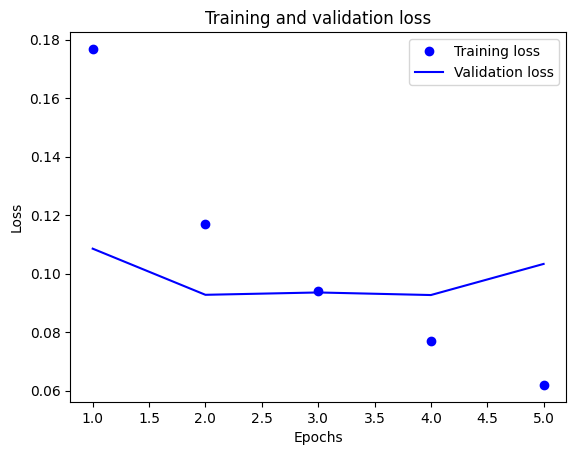

In [55]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

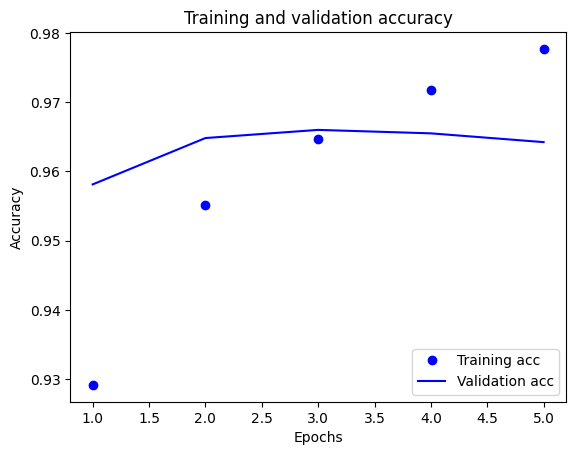

In [56]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()